In [1]:
import sys
sys.path.insert(0, '../')

import gymnasium as gym
print(f"Gym Version = {gym.__version__}")

import AddictiveReward

import numpy as np

from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium import spaces
import random
from numpy.random import choice
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional

Gym Version = 0.27.0


In [2]:
env = gym.make('AddictiveEnv_v1')

In [3]:
class QLearningAgent:
    def __init__(self, learning_rate: float,  initial_epsilon: float,   epsilon_decay: float,  final_epsilon: float,   discount_factor: float = 0.95):
        
        
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    
    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values
    
    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_values[state, action] 
        next_max = np.max(self.q_table[next_state, :])
        self.q_values[state, action] =  (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max) 

    def update(self, obs: int, action: int, reward: float, terminated: bool, next_obs: int):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)
        
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

In [14]:
learning_rate = 0.9
n_episodes = 1000
start_epsilon = 0.5

epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = QLearningAgent(
    learning_rate = 0.9,
    initial_epsilon = 0.9,
    epsilon_decay =  epsilon_decay,
    final_epsilon = 0.1,
)


In [15]:
# env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
addiction_states = []

In [18]:

for episode in tqdm(range(n_episodes)):
    
    obs, info = env.reset()
    done = False
    addicted = 0
    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)
        
        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        if obs == 8:
            addicted += 1
    addiction_states.append(addicted)
    agent.decay_epsilon()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.17it/s]


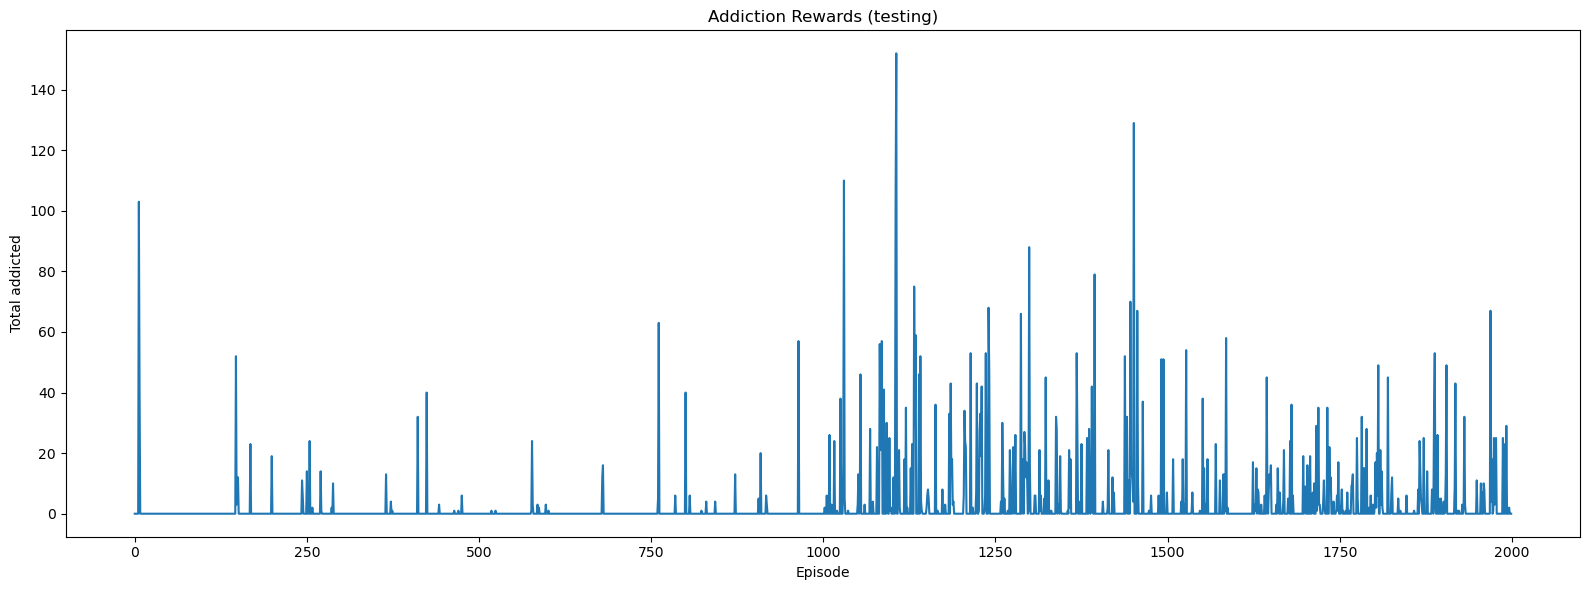

In [19]:
plt.figure(figsize=(16, 6))


plt.plot(addiction_states)
plt.title('Addiction Rewards (testing)')
plt.xlabel('Episode')
plt.ylabel('Total addicted')

plt.tight_layout()
plt.show()